# Set up

In [1]:
# pip install lime

In [2]:
import lime
import lime.lime_tabular
from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np
import pandas as pd
import sklearn.metrics

## Tabular data

### For Regression 

Dataset : [boston dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

In [3]:
boston = load_boston() # (506,13)

**Data Set Characteristics:**  

Number of Instances: 506 

Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

Attribute Information (in order):
- CRIM     per capita crime rate by town
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- RM       average number of rooms per dwelling
- AGE      proportion of owner-occupied units built prior to 1940
- DIS      weighted distances to five Boston employment centres
- RAD      index of accessibility to radial highways
- TAX      full-value property-tax rate per 10,000 US dollars.
- PTRATIO  pupil-teacher ratio by town
- B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT    % lower status of the population
- MEDV     Median value of owner-occupied homes in 1000's US dollars.

In [4]:
# sklearn返回類似字典的對象，屬性是：' data '，要學習的數據，' target '，回歸目標，
#' DESCR '，數據集的完整描述，' filename'，波士頓的物理位置csv數據集。

boston.keys() #dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
boston.feature_names # array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                           # 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')


array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
# Use random forest method to train data
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)

In [6]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(boston.data, boston.target, train_size=0.80)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
rf.fit(train, labels_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [8]:
print('Random Forest MSError', np.mean((rf.predict(test) - labels_test) ** 2))


Random Forest MSError 6.887515712745033


In [9]:
print('MSError when predicting the mean', np.mean((labels_train.mean() - labels_test) ** 2))

MSError when predicting the mean 87.71845389533128


In [10]:
categorical_features = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names,
            class_names=['price'], categorical_features=categorical_features, verbose=True, mode='regression')

In [12]:
i = 25
exp = explainer.explain_instance(test[i], rf.predict, num_features=5)

Intercept 23.449875596488386
Prediction_local [24.09080884]
Right: 21.506900000000147


In [13]:
exp.show_in_notebook(show_table=True)

In [14]:
# 前五個最可能影響房價的變數：RM, LSTAT, PTRATIO, TAX, NOX
exp.as_list()

[('5.88 < RM <= 6.21', -1.8695073365287023),
 ('6.77 < LSTAT <= 10.93', 1.821541864171722),
 ('17.40 < PTRATIO <= 19.10', 0.8321493196956512),
 ('330.00 < TAX <= 666.00', -0.49541675051665546),
 ('42.18 < AGE <= 76.70', 0.35216614200856594)]

In [15]:
np.random.seed(1)

### 訓練模型

使用iris dataset，並以隨機森林訓練。

In [16]:
iris = sklearn.datasets.load_iris()
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(iris.data, iris.target, train_size=0.80)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

0.9666666666666667

### 解釋預測

與text不同，此處需要訓練集。這是因為要計算每個特徵的訊息。如果特徵是數字，則計算平均值和標準差，並將其離散化為四分位數；如果特徵是類別的，則計算每個值的頻率。

In [19]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=iris.feature_names, class_names=iris.target_names,
                                                   discretize_continuous=True,mode = "classification")

In [20]:
i = np.random.randint(0, test.shape[0])
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=2, top_labels=1)

In [21]:
exp.show_in_notebook(show_table=True, show_all=False)

##  Text classifier

### 訓練分類器

我們首先需要先訓練一個分類器，之後才能以lime來判別分類器的運作。

在訓練這個分類器的過程中，使用的是20newsgroups這個dataset，並從中選取`'atheism'` `'christian'`兩個子集，以隨機森林的方式將其分類。

In [22]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

In [23]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

In [24]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

0.9187935034802783

可以看到用隨機森林分類後，所得出的f1_score效果還不錯

### 解釋預測

現在，我們試著用lime來看出隨機森林是如何分類的。

In [26]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [27]:
c = make_pipeline(vectorizer, rf)
explainer = LimeTextExplainer(class_names=class_names)

用explainer可以看到任意在測試集中的文檔，指定影響力最大的前幾個判斷依據，並顯示隨機森林對文檔分類的結果。

In [28]:
idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0, 1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 83
Probability(christian) = 0.466
True class: atheism


In [29]:
exp.as_list()

[('Host', -0.1386216844932411),
 ('Posting', -0.12268441602800574),
 ('NNTP', -0.12040273464340077),
 ('edu', -0.03594533052621992),
 ('Lines', 0.015163199610460813),
 ('post', -0.010011846866068272)]

使用`exp.as_list()`可以看到分類器的分類依據，可以發現其實這些字詞和主題並沒有那麼大的關連。

### 視覺化

我們可以將上述的結果，繪製成圖表，使得閱讀上更為容易。


Bad key savefig.frameon in file C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlibrc file f

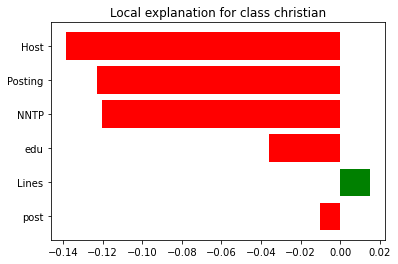

In [30]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [31]:
exp.show_in_notebook(text=True)

可以看到 Prediction probabilities、判斷依據、原始檔案，其中原始文檔的部分會將作為判斷依據的字進行標籤。

### 其他

無論是數值或類別資料，都可以使用Lime

模型除了隨機森林，也可以用boost之類的其他模型


## Image

In [32]:
import os
import keras
from keras.applications import inception_v3
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.4.3


### Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [33]:
inet_model = inception_v3.InceptionV3()

96116736/96112376 [==============================] - 5s 0us/step


In [34]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inception_v3.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

### Let's see the top 5 prediction for some image

40960/35363 [==================================] - 0s 0us/step
('n02099712', 'Labrador_retriever', 0.76364595)
('n02093428', 'American_Staffordshire_terrier', 0.023073826)
('n02099601', 'golden_retriever', 0.009859212)
('n02109047', 'Great_Dane', 0.009563552)
('n02108422', 'bull_mastiff', 0.009112368)


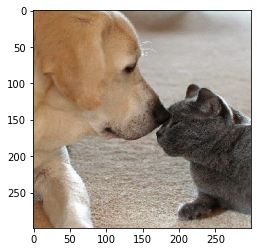

In [35]:
images = transform_img_fn(["cat-and-dog.jpg"])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

### Explanation
Now let's get an explanation

In [36]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [37]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=200)
explanation

### Now let's see the explanation for the top class ( Labrador_retriever)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [38]:
from skimage.segmentation import mark_boundaries

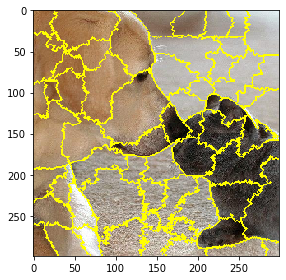

In [39]:
#Generate segmentation for image
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(images[0].astype('double'), kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0] 
skimage.io.imshow(skimage.segmentation.mark_boundaries(images[0]/2+0.5, superpixels))

In [40]:
#Generate perturbations
num_perturb = 100
np.random.seed(222)
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

[1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1]


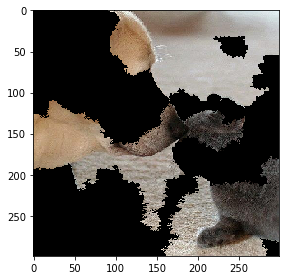

In [41]:
#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

#Show example of perturbations
print(perturbations[0]) 
skimage.io.imshow(perturb_image(images[0]/2+0.5,perturbations[0],superpixels))

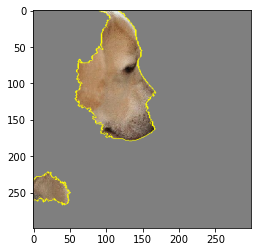

In [42]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

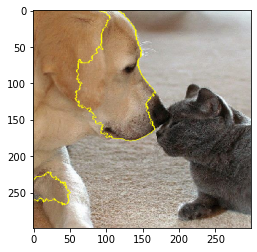

In [43]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We can also see the 'pros and cons' (pros in green, cons in red)

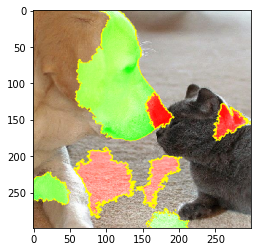

In [44]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

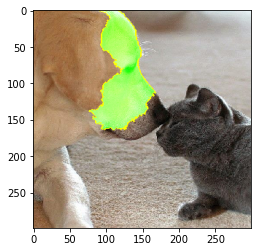

In [45]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

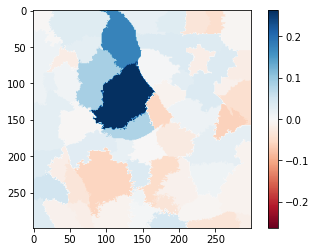

In [46]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Let's see the explanation for the second highest prediction

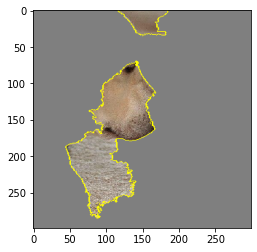

In [47]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

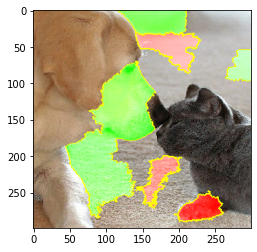

In [48]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))